análisis de sentimiento de un dataset

In [ ]:
#Cargamos los datasets

from google.colab import drive

drive.mount('/content/drive')
amazon_en_train = '/content/drive/MyDrive/XXXXXXXXXXXXXXXXXXXXXX.csv'
amazon_en_dev = '/content/drive/MyDrive/XXXXXXXXXXXXXXXXXXXXXXXXXX.csv'
amazon_en_test = '/content/drive/MyDrive/XXXXXXXXXXXXXXXXXXXXXXXXX.csv'

Mounted at /content/drive


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [ ]:
import pandas as pd

file_names = [(amazon_en_train, "train"), (amazon_en_dev, "dev"), (amazon_en_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name)
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,split
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture,train
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement,train
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home,train
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless,train
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc,train
...,...,...,...,...,...,...,...,...,...
4995,en_0681530,product_en_0198517,reviewer_en_0539725,5,"It's still early, but so far the scales seems ...",Very sleek.,en,drugstore,test
4996,en_0157408,product_en_0206198,reviewer_en_0605408,5,I’ve used this face mask a few times now and i...,... face mask a few times now and it works gre...,en,beauty,test
4997,en_0542558,product_en_0525205,reviewer_en_0727937,5,Great price. Good quality.,Five Stars,en,home,test
4998,en_0754850,product_en_0613095,reviewer_en_0643466,5,Fits my 2016 F150 XLT great. Now I dont have t...,2016 F150 XLT,en,automotive,test


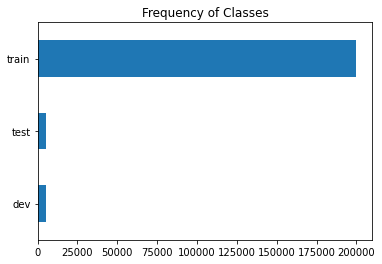

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

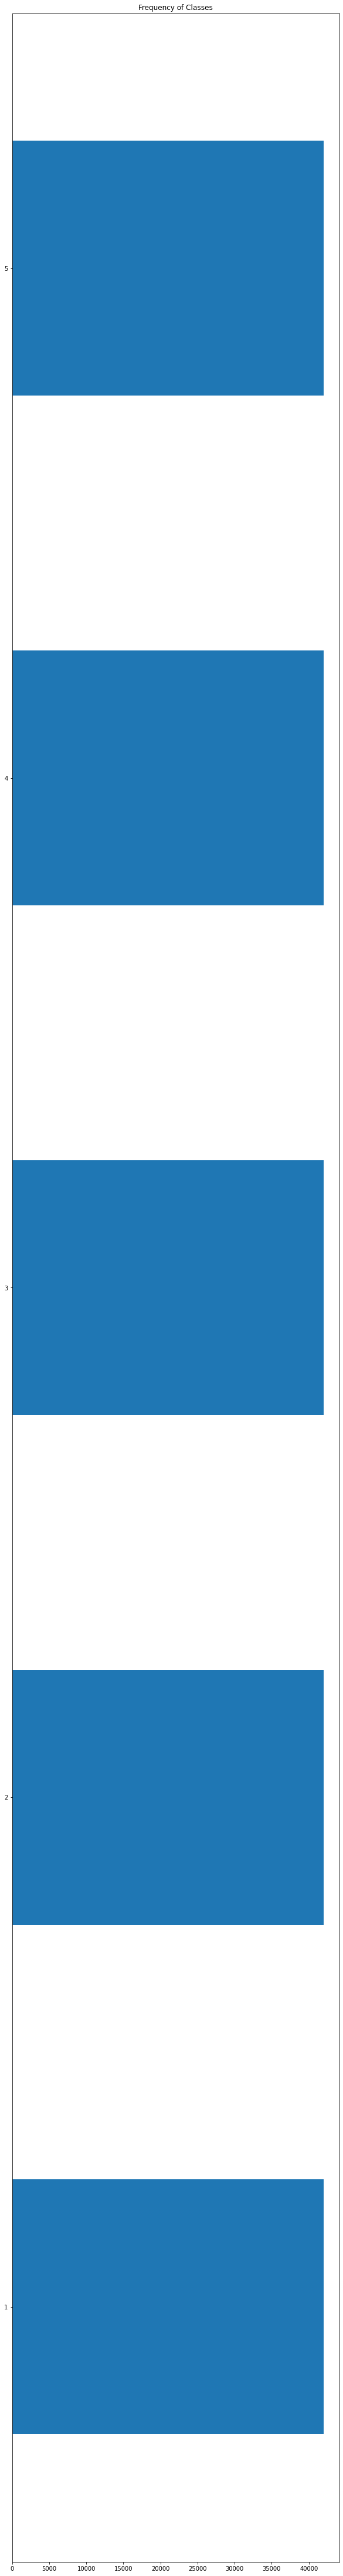

In [ ]:
# Distribucion de instancias por clases (i.e. estrellas)

df["stars"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Nos quedamos con las columnas que nos interesan
df = df[['review_body', 'stars', 'split']]
df

,review_body,stars,split
0,Arrived broken. Manufacturer defect. Two of th...,1,train
1,the cabinet dot were all detached from backing...,1,train
2,I received my first order of this product and ...,1,train
3,This product is a piece of shit. Do not buy. D...,1,train
4,went through 3 in one day doesn't fit correct ...,1,train
...,...,...,...
4995,"It's still early, but so far the scales seems ...",5,test
4996,I’ve used this face mask a few times now and i...,5,test
4997,Great price. Good quality.,5,test
4998,Fits my 2016 F150 XLT great. Now I dont have t...,5,test


Ahora vamos a generar una serie de características (features) que alimentarán al modelo de machine learning.

Para incorporar dichas características léxicas y sintácticas en un modelo de Naive Bayes multinomial utilizando scikit-learn, podemos utilizar un vectorizador que tenga en cuenta estas características. Un vectorizador es una herramienta que convierte una colección de documentos (en este caso, una columna de texto en un dataframe de pandas) en una matriz de características numéricas, que pueden utilizarse como entrada para un modelo de aprendizaje automático.

Existen diferentes vectorizadores que podemos utilizar, cada uno de ellos con diferentes opciones y configuraciones para procesar el texto y extraer características:

    CountVectorizer: vectorizador que cuenta la frecuencia de términos (palabras o conjuntos de palabras) en el texto y devuelve una matriz de conteo de términos.

    TfidfVectorizer: vectorizador que cuenta la frecuencia de términos en el texto y aplica una ponderación inversa de frecuencia de documento (TF-IDF) para reflejar la importancia de cada término en el conjunto de documentos.

    HashingVectorizer: vectorizador que utiliza una función de hash para codificar el texto en un espacio de características de dimensión fija, sin necesidad de construir un diccionario de términos explícito.

Cada uno de estos vectorizadores tiene diferentes opciones y parámetros que podemos utilizar para controlar cómo se procesa el texto y qué características se extraen. Por ejemplo, podemos utilizar el parámetro ngram_range para extraer n-gramas (conjuntos de n palabras consecutivas).

En este cuaderno vamos a usar, primeramente, CountVectorizer y más adelante TfidVectorizer. En el caso de CountVectorizer, cada fila en la matriz resultante corresponde a un texto y cada columna corresponde a una palabra o término específico en el vocabulario. Las entradas en la matriz son contadores de cuántas veces aparece cada palabra en cada documento.

Por ejemplo, consideremos las siguientes tres oraciones:

    "El gato se sentó en la estera"
    "El perro persiguió al gato"
    "La estera estaba cubierta de pelo de gato"

Si aplicamos CountVectorizer a estos documentos, podríamos crear un vocabulario de todas las palabras únicas en los documentos, como este:

    "el"
    "gato"
    "se"
    "sentó"
    "en"
    "la"
    "estera"
    "perro"
    "persiguió"
    "a"
    "estaba"
    "cubierta"
    "de"
    "pelo"

La matriz resultante podría verse así:
	el	gato	se	sentó	en	la	estera	perro	persiguió	a	estaba	cubierta	de	pelo



```
text 1	1	1	1	1	1	1	1	0	0	0	0	0	0	0
text 2	1	1	0	0	0	0	0	1	1	1	0	0	0	0
text 3	1	1	0	0	0	1	1	0	0	0	1	1	1	1
```


La matriz resultante a menudo se le llama "matriz de términos de documentos".

En cuanto a la función que vamos a aplicar, la función CountVectorizer crea un objeto que se puede utilizar para convertir un conjunto de textos (en este caso, las reviews de Amazon) en una matriz de características numéricas, como se describe anteriormente. Los parámetros de la función son opcionales y se pueden utilizar para personalizar el comportamiento del objeto.

    stop_words: Una lista de palabras que se deben excluir del vocabulario. En este caso, se especifica que se deben excluir las palabras más comunes en inglés ("english").
    ngram_range: Una tupla que especifica el rango de tamaño de los n-gramas (secuencias de n palabras) que se deben incluir en el vocabulario. En este caso, se especifica que se deben incluir tanto 1-gramas como 2-gramas.
    tokenizer: Una función que se utiliza para dividir los documentos en tokens (palabras o frases).

Otros parámetros opcionales incluyen:

    max_df: Un límite superior para la frecuencia de términos (proporción de documentos en los que aparece un término). Los términos que aparecen en una proporción mayor de documentos que el límite especificado se excluyen del vocabulario.
    min_df: Un límite inferior para la frecuencia de términos. Los términos que aparecen en una proporción menor de documentos que el límite especificado se excluyen del vocabulario.
    max_features: Un límite para el número de términos incluidos en el vocabulario. Si se especifica, solo se incluirán los términos más frecuentes hasta alcanzar el límite especificado.
    lowercase: Una bandera que indica si se deben convertir todas las palabras a minúsculas antes de construir el vocabulario.
    vocabulary: Un diccionario que asigna palabras a índices en el vocabulario. Si se especifica, se usará este diccionario en lugar de construir uno nuevo a partir de los textos.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+') # Más rápido y eficiente al utilizar regex
cv = CountVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)

Vamos a convertir las reviews en una matriz de cuentas de tokens. Pero antes de nada, vamos a dividir nuevamente el dataframe en tres, uno por split, aleatorizar los conjuntos de datos, que estaban ordenados en función del número de estrellas.

In [ ]:
import random
random.seed(0)

df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'dev']
df_test = df[df['split'] == 'test']

df_train = df_train.sample(frac=1)
df_valid = df_valid.sample(frac=1)
df_test = df_test.sample(frac=1)

df_train

,review_body,stars,split
103189,"They are definitely no show, more than others ...",3,train
178691,These shoes are wonderful. The first time I wo...,5,train
129642,I've had trouble sleeping for years and now I'...,4,train
83823,The nose bridge attaches to the goggles at a f...,3,train
16870,Quit working on first use. Refund processed.,1,train
...,...,...,...
3242,They worked well until they stopped working. I...,1,train
113462,After reading the reviews I was surprised that...,3,train
44547,"works well enough but getting it ready to use,...",2,train
128177,The plastic bucket got cut on the edge from th...,4,train


La primera línea, X_train = cv.fit_transform(df_train['review_body']), está utilizando el objeto CountVectorizer para convertir el texto en la columna 'review_body' del dataframe de entrenamiento df_train en una matriz de cuentas de tokens. Además, está ajustando los parámetros del vectorizador (por ejemplo, el vocabulario) en función del texto del conjunto de entrenamiento.

La segunda línea, X_valid = cv.transform(df_test['review_body']), está utilizando el objeto CountVectorizer para convertir el texto en la columna 'review_body' del dataframe de validación df_test en una matriz de cuentas de tokens. Sin embargo, en este caso no se están ajustando los parámetros del vectorizador, sino que se están utilizando los parámetros ajustados previamente en el conjunto de entrenamiento.

La tercera línea, X_test = cv.transform(df_test['review_body']), es similar a la segunda línea, pero en este caso se está utilizando el texto del conjunto de evaluación en lugar del conjunto de validación.

Estas líneas de código se utilizan para preparar los datos de texto para su procesamiento por parte del clasificador de Naive Bayes multinomial. Las últimas tres líneas de código se utilizan para convertir las etiquetas en una matriz de etiquetas para su procesamiento por parte del clasificador de Naive Bayes multinomial.

In [ ]:
X_train = cv.fit_transform(df_train['review_body'])
X_valid = cv.transform(df_valid['review_body'])
X_test = cv.transform(df_test['review_body'])

y_train = df_train['stars']
y_valid = df_valid['stars']
y_test = df_test['stars']

Antes de evaluar el dataset de evaluación, vamos a encontrar los mejores hiperparámetros, utilizando para ello el dataset de validación.

En la primera línea, from sklearn.naive_bayes import MultinomialNB, se está importando la clase MultinomialNB del módulo naive_bayes de scikit-learn. Esta clase implementa el clasificador de Naive Bayes Multinomial, que se utiliza para clasificar documentos en varias categorías utilizando una matriz de cuentas de tokens.

En la segunda línea, from sklearn.model_selection import GridSearchCV, se está importando la clase GridSearchCV del módulo model_selection de scikit-learn. Esta clase implementa la búsqueda exhaustiva por rejilla, que permite buscar los mejores hiperparámetros para un modelo utilizando validación cruzada.

En la cuarta línea, clf = MultinomialNB(), se está creando un objeto de la clase MultinomialNB, que representa el clasificador de Naive Bayes Multinomial.

En la sexta línea, param_grid = {'alpha': [0.1, 1, 10]}, se está definiendo una rejilla de hiperparámetros para la búsqueda exhaustiva por rejilla. En este caso, se está buscando el mejor valor del hiperparámetro alpha, que es un parámetro de suavizado en el clasificador de Naive Bayes Multinomial. La rejilla incluye tres posibles valores para alpha: 0.1, 1 y 10.

En la séptima línea, grid_search = GridSearchCV(clf, param_grid, cv=5), se está creando un objeto de la clase GridSearchCV, que representa la búsqueda exhaustiva por rejilla. Este objeto se inicializa con el clasificador clf y la rejilla de hiperparámetros param_grid, y utiliza una validación cruzada de cinco divisiones (cv=5) para evaluar los diferentes valores de hiperparámetros.

En la octava línea, grid_search.fit(X_train, y_train), se está ajustando el objeto grid_search al conjunto de entrenamiento X_train y las etiquetas y_train. Esto implica entrenar un modelo con cada posible combinación de hiperparámetros y evaluar el rendimiento en el conjunto de entrenamiento utilizando validación cruzada.

En la décima línea, print("Best hyperparameters:", grid_search.best_params_), se está imprimiendo el mejor conjunto de hiperparámetros encontrado por la búsqueda exhaustiva por rejilla. Este conjunto de hiperparámetros es el que ha obtenido el mejor rendimiento en el conjunto de entrenamiento utilizando validación cruzada.

En la undécima línea, val_score = grid_search.score(X_valid, y_valid), se está evaluando el rendimiento del clasificador con los mejores hiperparámetros en el conjunto de validación X_valid y y_valid. El resultado se almacena en la variable val_score, que representa la precisión del clasificador en el conjunto de validación.

En la duodécima línea, print("Validation accuracy:", val_score), se está imprimiendo la precisión del clasificador en el conjunto de validación. Esta precisión puede utilizarse como una medida del rendimiento del modelo y para comparar diferentes modelos y hiperparámetros.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

clf = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

Best hyperparameters: {'alpha': 1}
Validation accuracy: 0.4848


Las siguientes líneas de código sirven para ajustar el clasificador de Naive Bayes Multinomial con el mejor conjunto de hiperparámetros encontrado en la búsqueda exhaustiva por rejilla y evaluar el rendimiento del modelo en el dataset de evaluación.

En la primera línea, clf = MultinomialNB(alpha=val_score), se está creando un nuevo objeto de la clase MultinomialNB con el mejor valor de alpha encontrado en la búsqueda exhaustiva por rejilla. Este valor se almacena en la variable val_score, y se pasa como argumento al constructor de la clase MultinomialNB.

En la tercera línea, clf.fit(X_train, y_train), se está ajustando el clasificador clf al dataset de entrenamiento X_train y las etiquetas y_train. Esto implica entrenar un modelo utilizando el conjunto de entrenamiento y el mejor conjunto de hiperparámetros encontrado.

En la quinta línea, test_score = clf.score(X_test, y_test), se está evaluando el rendimiento del clasificador en el conjunto de prueba X_test y y_test. El resultado se almacena en la variable test_score, que representa la precisión del clasificador en el conjunto de evaluación.

In [ ]:
clf = MultinomialNB(alpha=val_score)

clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.4746


Evaluamos el macro-F1 y el F1 ponderado, así como la precisión, cobertura y F1 de cada clase.

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.56      0.60      0.58      1000
           2       0.38      0.35      0.37      1000
           3       0.36      0.35      0.36      1000
           4       0.42      0.43      0.43      1000
           5       0.63      0.63      0.63      1000

    accuracy                           0.47      5000
   macro avg       0.47      0.47      0.47      5000
weighted avg       0.47      0.47      0.47      5000



Vamos a probar TfidfVectorizer para ver si arroja mejores resultados. Para ello, emplearemos las mismas características.

TfidfVectorizer se utiliza para vectorizar documentos basándose en la frecuencia de términos (Term Frequency, TF). La frecuencia de términos (TF) es una medida del número de veces que un término aparece en un documento. Un término con alta frecuencia en un documento se considera importante para ese documento y, por lo tanto, se le da más peso.

Por ejemplo, supongamos que tenemos un conjunto de documentos que contienen las palabras "gato", "perro" y "pájaro". Si la palabra "gato" aparece en 3 de los 5 documentos, la frecuencia inversa del término (IDF) sería ln(5/3) = 0,405. Si la palabra "gato" aparece 3 veces en un documento específico, la frecuencia del término en el documento (TF) sería 3. La ponderación TF-IDF de la palabra "gato" en este documento sería 3 * 0,405 = 1,215.

CountVectorizer también se utiliza para vectorizar documentos, como ya hemos visto, pero en lugar de basarse en la frecuencia de términos, se basa en la cantidad de veces que un término aparece en un documento (esto es, en un conteo). Esto significa que un término con alta frecuencia en un documento recibirá el mismo peso, independientemente de la longitud del documento.

En resumen, TfidfVectorizer da más peso a términos que son importantes para un documento en particular y menos peso a términos comunes en todos los documentos, mientras que CountVectorizer da el mismo peso a todos los términos independientemente de su importancia para el documento o para el conjunto de documentos.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english',ngram_range = (1,2),tokenizer = token.tokenize)

X_train = tfidf.fit_transform(df_train['review_body'])
X_valid = tfidf.transform(df_valid['review_body'])
X_test = tfidf.transform(df_test['review_body'])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

clf = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

Best hyperparameters: {'alpha': 10}
Validation accuracy: 0.4918


In [ ]:
clf = MultinomialNB(alpha=val_score)

clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.484


In [ ]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.57      0.62      0.59      1000
           2       0.39      0.38      0.38      1000
           3       0.37      0.35      0.36      1000
           4       0.44      0.44      0.44      1000
           5       0.64      0.63      0.64      1000

    accuracy                           0.48      5000
   macro avg       0.48      0.48      0.48      5000
weighted avg       0.48      0.48      0.48      5000



Vamos a añadir las predicciones hechas por el modelo al dataframe.

In [ ]:
df_test['NB_predictions'] = y_pred
df_test

,review_body,stars,split,NB_predictions
1611,These sheets are soft as silk but they snag ba...,2,test,4
3314,This is a great item to keep your dog from get...,4,test,4
4337,I love this tea kettle! It’s so easy to use an...,5,test,5
4845,Soft and perfect for our 1 year old.,5,test,5
688,Waste of money smfh sooo upset,1,test,1
...,...,...,...,...
4848,Michener the philosopher of the 20th Century c...,5,test,4
4720,Easy install and feel taught and sturdy.,5,test,5
275,They don’t even work.,1,test,1
313,Didn’t work at all for what I needed. Based on...,1,test,3


Ahora vamos a calcular los valores de pérdida. En el modelo Naive Bayes multinomial, los valores de pérdida representan la inversa de la probabilidad de la predicción correcta. Es decir, a mayor valor de pérdida, menor es la probabilidad de que la predicción sea correcta. Es importante tener en cuenta que los valores de pérdida son una medida de confianza en la predicción, pero no necesariamente una medida de precisión.

Es importante tener en cuenta que el modelo Naive Bayes multinomial es un modelo probabilístico, por lo que las predicciones se basan en la probabilidad de que una clase determinada ocurra dado un conjunto de características. Por lo tanto, la pérdida se calcula como 1 - probabilidad de la predicción correcta.

In [ ]:
probabilities = clf.predict_proba(X_test)
loss_values = 1 - probabilities[range(len(y_pred)), y_pred-1]

In [ ]:
df_test['loss_values_NB'] = loss_values
df_test
#df_test.sort_values(by='loss_values_NB', ascending=False, inplace=True)

,review_body,stars,split,NB_predictions,loss_values_NB
1611,These sheets are soft as silk but they snag ba...,2,test,4,0.670383
3314,This is a great item to keep your dog from get...,4,test,4,0.698331
4337,I love this tea kettle! It’s so easy to use an...,5,test,5,0.531701
4845,Soft and perfect for our 1 year old.,5,test,5,0.550662
688,Waste of money smfh sooo upset,1,test,1,0.173197
...,...,...,...,...,...
4848,Michener the philosopher of the 20th Century c...,5,test,4,0.630655
4720,Easy install and feel taught and sturdy.,5,test,5,0.508329
275,They don’t even work.,1,test,1,0.486300
313,Didn’t work at all for what I needed. Based on...,1,test,3,0.582132


Es normal que haya grandes valores de pérdida para predicciones correctas, ya que significa que la probabilidad de que la predicción sea correcta es baja. Esto puede deberse a varias razones, como la escasez de datos para esa clase en particular o la presencia de características que dificultan la predicción correcta. En cualquier caso, es importante analizar los datos y comprender por qué se están obteniendo estos valores de pérdida para poder mejorar el modelo en el futuro.

# Clasificador de máquinas de vectores de soporte lineal

Vamos a utilizar el clasificador tal cual, aunque también podríamos hacer una búsqueda de los mejores hiperparámetros. En tal caso, la línea de código, param_grid = {'C': [0.1, 1, 10]}, crea un diccionario que define el conjunto de hiperparámetros que se va a optimizar utilizando GridSearchCV. En este caso, el diccionario solo tiene una clave, 'C', que corresponde al parámetro de regularización del modelo de SVM. El valor de esta clave es una lista de tres valores posibles para el parámetro C, [0.1, 1, 10]. Esto significa que GridSearchCV prueba tres valores diferentes para el parámetro C: 0.1, 1 y 10.

La otra línea de código, grid_search = GridSearchCV(clf, param_grid, cv=5), crea una instancia de GridSearchCV y la almacena en la variable grid_search. Al crear la instancia, se le pasan tres argumentos:

    clf: El modelo que se va a optimizar. En este caso, es una instancia de SVC con el kernel especificado como 'linear'.

    param_grid: El diccionario que define los hiperparámetros a optimizar y sus posibles valores.

    cv: El número de veces que se va a dividir el conjunto de entrenamiento para validar los diferentes valores de los hiperparámetros. En este caso, se está especificando que se va a utilizar una validación cruzada de k-fold con k=5, lo que significa que se va a dividir el conjunto de entrenamiento en 5 subconjuntos y se va a entrenar el modelo con 4 de ellos y validarlo con el quinto, iterando sobre todas las combinaciones posibles de subconjuntos de entrenamiento y validación.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

clf = LinearSVC()

#param_grid = {'C': [0.1, 1, 10]}
#grid_search = GridSearchCV(clf, param_grid, cv=5)
#grid_search.fit(X_train, y_train)

#print("Best hyperparameters:", grid_search.best_params_)

Los dos asteriscos (**) en la línea clf = LinearSVC(**grid_search.best_params_) indican que se está utilizando la sintaxis de desempaquetado de argumentos de palabra clave (keyword arguments). Esta sintaxis permite pasar un diccionario como argumentos de una función o método, con cada clave del diccionario convirtiéndose en un argumento y cada valor convirtiéndose en el valor de ese argumento.

En este caso, grid_search.best_params_ es un diccionario que contiene los mejores hiperparámetros encontrados por GridSearchCV, y al pasarlo como argumentos de la función SVC con la sintaxis de desempaquetado de argumentos de palabra clave, se está creando una instancia de SVC con los mejores hiperparámetros encontrados. Por ejemplo, si grid_search.best_params_ es {'C': 1}, entonces la línea clf = LinearSVC(**grid_search.best_params_) es equivalente a clf = LinearSVC(C=1).

In [ ]:
#clf = LinearSVC(**grid_search.best_params_)
clf.fit(X_train, y_train)

test_score = clf.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.4818


In [ ]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

           1       0.57      0.62      0.59      1000
           2       0.39      0.37      0.38      1000
           3       0.36      0.30      0.33      1000
           4       0.44      0.40      0.42      1000
           5       0.58      0.72      0.64      1000

    accuracy                           0.48      5000
   macro avg       0.47      0.48      0.47      5000
weighted avg       0.47      0.48      0.47      5000



Vamos a añadir las predicciones hechas por el modelo al dataframe.

In [ ]:
df_test['SVM_predictions'] = y_pred
df_test

,review_body,stars,split,NB_predictions,loss_values_NB,SVM_predictions
1611,These sheets are soft as silk but they snag ba...,2,test,4,0.670383,4
3314,This is a great item to keep your dog from get...,4,test,4,0.698331,3
4337,I love this tea kettle! It’s so easy to use an...,5,test,5,0.531701,5
4845,Soft and perfect for our 1 year old.,5,test,5,0.550662,5
688,Waste of money smfh sooo upset,1,test,1,0.173197,1
...,...,...,...,...,...,...
4848,Michener the philosopher of the 20th Century c...,5,test,4,0.630655,5
4720,Easy install and feel taught and sturdy.,5,test,5,0.508329,5
275,They don’t even work.,1,test,1,0.486300,1
313,Didn’t work at all for what I needed. Based on...,1,test,3,0.582132,3


Ahora veamos aquellas predicciones con su pérdida correspondiente. Los valores de pérdida en un modelo de SVM lineal se refieren a la distancia del punto de predicción al límite de decisión del modelo. En el caso de predicciones correctas, los puntos de predicción deben estar a una distancia suficientemente grande del límite de decisión para ser clasificados de manera segura en la clase correcta. Si un punto de predicción está demasiado cerca del límite de decisión, esto indica que el modelo está "incierto" sobre la clase a la que debe asignarlo. En general, cuanto mayor sea el valor de pérdida, mayor será la confianza del modelo en la predicción correspondiente.

Esta línea de código obtiene el valor de pérdida de cada predicción realizada por el modelo de SVM lineal, basándose en el conjunto de evaluación. Para ello, primero se invoca el método decision_function del objeto clf, pasándole como argumento el conjunto de prueba X_test. Este método devuelve una matriz con tantas filas como elementos haya en X_test y tantas columnas como clases haya en el conjunto de entrenamiento. Cada elemento de esta matriz es la distancia de cada elemento de X_test con el límite de decisión correspondiente a cada clase.

A continuación, se seleccionan las filas de la matriz que corresponden a cada predicción realizada por el modelo (que se encuentran en y_pred). Esto se hace con el índice range(len(y_pred)), que es una lista con todos los índices de las filas de la matriz. A continuación, se seleccionan las columnas de la matriz que corresponden a cada predicción realizada por el modelo (que se encuentran en y_pred). Esto se hace con el índice y_pred-1, que es una lista con todos los índices de las columnas de la matriz.

Finalmente, se devuelve una lista con todos los elementos de la matriz seleccionados con estos índices. Esta lista representa los valores de pérdida de cada predicción realizada por el modelo de SVM lineal en el conjunto de prueba.

In [ ]:
# Calculamos la distancia de cada predicción con el límite de decisión
loss_values = clf.decision_function(X_test)[range(len(y_pred)), y_pred-1]
loss_values

array([-0.22544364, -0.18967984,  0.42818813, ...,  0.54222882,
        0.05481622,  0.05367755])

In [ ]:
df_test['loss_values_SVM'] = loss_values
df_test.drop('split', axis=1, inplace=True)
df_test.sort_values(by='loss_values_NB', ascending=False, inplace=True)
df_test

,review_body,stars,NB_predictions,loss_values_NB,SVM_predictions,loss_values_SVM
1315,you cant see your shot very good at all!!,2,1,0.792034,4,-0.600854
2186,Apparently 2 Billion is not very many in the w...,3,3,0.790889,1,-0.468954
4256,Seems to be accurate and I like that i dont ha...,5,1,0.789542,3,-0.438399
1021,This works as described..clear NO IT'S MILKY.....,2,3,0.788050,5,-0.630070
1975,Too thin but will do in a crunch.,2,4,0.787179,1,-0.280629
...,...,...,...,...,...,...
778,"Not only was the product poorly packaged, it d...",1,1,0.039398,1,2.428558
24,Shame you can't give it 0 stars I ordered this...,1,1,0.026337,1,1.394814
898,This product was defective and didn’t work. I ...,1,1,0.024121,1,1.238547
75,The Product arrived broken. Amazon immediately...,1,1,0.018256,1,2.304993


Los valores de pérdida en un modelo SVM lineal no necesariamente tienen una relación directa con la precisión de la predicción. Una gran pérdida positiva o negativa indica que el punto de predicción está muy cerca del límite de decisión, lo que significa que el modelo está "incierto" sobre la clase a la que debe asignarlo. Aunque el modelo tenga mayor confianza en la predicción correspondiente, esto no necesariamente significa que la predicción sea correcta.

Por otro lado, los valores de pérdida cercanos a cero pueden ser indicativos de que el modelo tiene menos confianza en la predicción, pero no necesariamente indican que la predicción sea incorrecta. Es importante tener en cuenta que los valores de pérdida son solo una medida de la distancia del punto de predicción al límite de decisión, y no necesariamente indican la precisión de la predicción en sí.